In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time

In [2]:
def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 9999

Customer = namedtuple("Customer", "service_time arrival_time patience_time")
# example: c = Customer(service_time = 1, time_remaining = 0.5, arrival_time = 2)

def printarray(a):
    print(np.around(a, 3))
    
def customer(service_time=inf(), arrival_time=-1, patience_time=inf()):
    return Customer(service_time=service_time, arrival_time=arrival_time, patience_time=patience_time)

In [57]:
list(range(3))

[0, 1, 2]

In [189]:
# Example 2: M/M/c+M not PS (normal) queue (not necessarily) starting as empty

# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers
# Tmax = time horizon

def Exercise2(lambd=4, mu=2, gamma = 6, c = 3, N0=5, Tmax=10):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0]  # initial state of the system
    
    # customers currently being served by a server
    remaining_times = [customer(exp(mu), 0, inf()) for _ in range(min(c, N0))]
    
    # customers that are waiting to be served by a server
    queue = [customer(inf(), 0, exp(gamma)) for _ in range(N0 - c)]
    
    # times spent by users inside the system
    waiting_times = []
    
    # to calculate the probability someone has to wait in the queue
    p_wait_num = 0
    p_wait_denom = 0
    
    # first event must be an arrival
    next_arrival = exp(lambd)
    if len(remaining_times) > 0:
        remaining_times.sort(key=lambda x: x.service_time, reverse=False)
        next_departure = remaining_times[0].service_time
    else:
        next_departure = inf()

    if len(queue) > 0:
        queue.sort(key=lambda x: x.patience_time, reverse=False)
        next_abandonment = queue[0].patience_time
    else:
        next_abandonment = inf()
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        
        T.append(min(next_arrival, next_departure, next_abandonment))
            
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1]+1) 
            if len(remaining_times) < c:
                service_time = exp(mu)
                remaining_times.append(customer(T[-1] + service_time, T[-1], inf()))
            else:
                patience_time = exp(gamma)
                queue.append(customer(inf(), T[-1], T[-1] + patience_time))
                p_wait_num += 1
            p_wait_denom+=1    
            next_arrival = T[-1] + exp(lambd)
            #print("ARRIVAL %.3f departure %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1]-1)
            remaining_times.sort(key=lambda x: x.service_time, reverse=False)
            popped_customer = remaining_times.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                queue.sort(key=lambda x: x.arrival_time, reverse=False)
                next_to_enter = queue.pop(0)
                service_time = exp(mu)
                remaining_times.append(customer(T[-1] + service_time, next_to_enter.arrival_time, inf()))
            #print("arrival %.3f DEPARTURE %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### ABANDONMENT ##### 
        else: 
            N.append(N[-1]-1)
            queue.sort(key=lambda x: x.patience_time, reverse=False)
            popped_customer = queue.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
            #print("arrival %.3f departure %.3f ABANDONMENT %.3f" % (next_arrival, next_departure, next_abandonment))
        
        if len(remaining_times) > 0:
            remaining_times.sort(key=lambda x: x.service_time, reverse=False)
            next_departure = remaining_times[0].service_time
        else:
            next_departure = inf()

        if len(queue) > 0:
            queue.sort(key=lambda x: x.patience_time, reverse=False)
            next_abandonment = queue[0].patience_time
        else:
            next_abandonment = inf()

    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, (p_wait_num)/(p_wait_denom)

In [87]:
def E_C(rho, c):
    v1  = rho**c / math.factorial(c)
    v2  = c / (c - rho)
    v3 = sum([rho**k / math.factorial(k) for k in range(c)])
    Num = v1 * v2
    Den = v3 + (v1 * v2)
    return Num / Den

def avg_num_in_system(rho, c):
    a1 = rho / (c - rho)
    ec = E_C(rho, c)
    return a1*ec + rho

In [88]:
print("Testing with no abandonment")
lambd = 4
mus = [2, 4, 5, 8]
rhos = [2, 1, 0.8, 0.5]
servers = [15, 3]
for i in range(4):
    _, N, W, p_wait = Exercise2(lambd, mus[i], -1, servers[1], 0, Tmax=2000)
    print("P(waiting) %.3f vs. Erlang C %.3f" % (p_wait, E_C(rhos[i], servers[1])))
_, N, W, p_wait = Exercise2(4, 4, -1, servers[0], 0, Tmax=2000)
print("P(waiting) %.3f vs. Erlang C %.3f" % (p_wait, E_C(1, servers[0])))

Testing with no abandonment
P(waiting) 0.463 vs. Erlang C 0.444
P(waiting) 0.081 vs. Erlang C 0.091
P(waiting) 0.052 vs. Erlang C 0.052
P(waiting) 0.014 vs. Erlang C 0.015
P(waiting) 0.000 vs. Erlang C 0.000


In [226]:
_, N, W, p_wait = Exercise2(2, -1, 1, 15, 0, Tmax=1000)

In [227]:
print(p_wait)

0.9925187032418953


In [228]:
print(mean(W))

0.9867856751057753


In [229]:
print(var(W))

0.9584522359890275


In [230]:
print(mean(N))

17.480460921843687


In [231]:
print(var(N))

2.7591372625009543


Text(0.5,1,'Number of clients in the M/M/C+M queue 4/5/3+5')

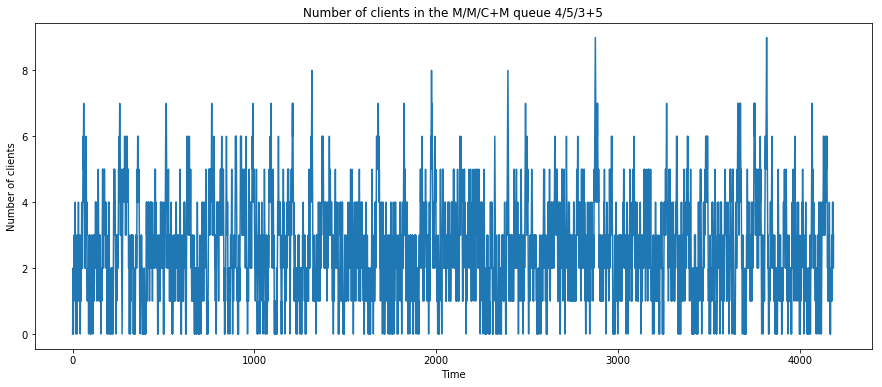

In [159]:
figure(figsize=(15,6))
plot(range(len(N)), N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue 4/5/3+5')

In [160]:
mean(N[400:])

2.63365029054411

In [161]:
var(N[400:])

2.250626770466107

In [135]:
_, N, W, p_wait = Exercise2(6, 2, 2, 15, 0, Tmax=1000)

Text(0.5,1,'Number of clients in the M/M/C+M queue 4/5/3+5')

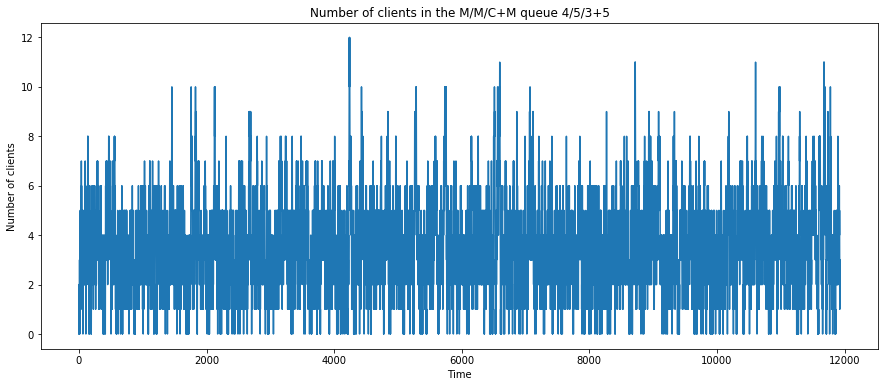

In [136]:
figure(figsize=(15,6))
plot(range(len(N)), N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C+M queue 4/5/3+5')

In [137]:
mean(N)

3.5147551978537894

In [95]:
N[500:525]

[0, 1, 0, 1, 0, 1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 3, 2, 1, 0, 1, 0, 1, 0, 1, 2]

In [73]:
def geom(p, k):
    return (1-p)*p**k
P       = [geom(0.8, k) for k in range(50)] # steady state pobabilities

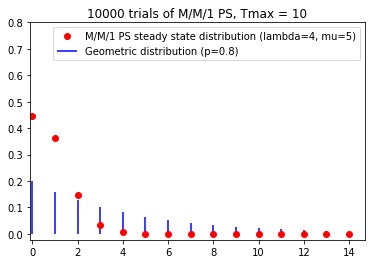

In [74]:
vlines(range(15),0,P[:15],colors='b',label="Geometric distribution (p=0.8)")
plot(range(15), Ns[:15],'ro',label="M/M/1 PS steady state distribution (lambda=4, mu=5)")
axis(xmin=-.1,ymax=.8)
title("10000 trials of M/M/1 PS, Tmax = 10")
legend()

In [185]:
# WRONG -- SHOULD NOT BE TWO QUEUES HERE

def MM1PS(C=3,lambd=4,mu=2.,N0=0,Tmax=100):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0] # initial state of the system
    
    # remaining service time and arrival times of customers in service
    remaining_times = [customer() for k in range(C)]
    num_in_service = 0
    
    # times spent by users inside the system
    waiting_times = []
    
    # customers waiting for service to become available, by their arrival times
    queue = []
    
    # first event must be an arrival
    next_arrival = exp(lambd)
    next_departure = inf()
    
    #printarray(T)
    #printarray(N)
    while T[-1] < Tmax:
        t_temp = T[-1]
        if num_in_service > 0:
            remaining_times = [decrease_time_remaining(x, (T[-1]-t_temp)/num_in_service) for x in remaining_times]
        
        # arrival
        if next_arrival < next_departure:
            #print("Processing an arrival; next arrival %.3f next departure %.3f" %(next_arrival, next_departure))
            T.append(next_arrival)
            N.append(N[-1]+1)
            # if there is no free server, add the arrival to the queue
            if remaining_times[C - 1].service_time < inf():
                queue.append(T[-1])
            # otherwise, assign the customer to the server
            else:
                service_time = exp(mu)
                remaining_times.append(customer(service_time, service_time, T[-1]))
                remaining_times.sort(key=lambda x: x.time_remaining, reverse=False)
                num_in_service += 1
            next_arrival = T[-1] + exp(lambd)
            
            #print("Next Arrival %f" % (next_arrival))
        
        # departure
        else: 
            #print("Processing a departure; next arrival %.3f next departure %.3f" %(next_arrival, next_departure))
            T.append(next_departure)
            N.append(N[-1]-1)
            popped_customer = remaining_times.pop(0)
            
            # if there is no queue, the server is free
            if len(queue) == 0:
                remaining_times.append(customer())
                num_in_service -= 1
            # otherwise, take someone off the queue
            else:
                arrival_time = queue.pop(0)
                service_time = exp(mu)
                remaining_times.append(customer(service_time, service_time, arrival_time))
            remaining_times.sort(key=lambda x: x.time_remaining, reverse=False)
            
            print(popped_customer)
            # process the departure
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
        
        printarray(T)
        printarray(N)
        if N[-1] == 0:
            next_departure = inf()
        else:
            next_departure = T[-1] + remaining_times[0].time_remaining * num_in_service
        #print("Next Departure %f" % (next_departure))
        
    T  = T[:-1] # event after Tmax is discarded
    N  = N[:-1]
    return T,N,waiting_times